# Discovering genes likely associated with the development of brain lower grade glioma

Documentation: http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variants_in_region

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements.txt

Since we'll send some requets in this demo, before starting it may be useful to write a simple resusable function to make a request and check the response to show the errors, if any.

In [1]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

def post_request(to: str, argument, print_status_code=True, print_warnings=True, timeout=None):
    resp = requests.post(to, json=argument, timeout=timeout)
    if print_status_code:
        print(' response status code: {}'.format(resp.status_code))
    res_body = resp.json()
    if resp.status_code != 200:
        print(res_body)
    if print_warnings:
        print('warnings ?: {}'.format(res_body.get('notice')))
    return res_body

For this demo we took inspiration from the DiffMut technique developed at Singh-Lab (credits at the end) for differential analysis between somatic mutations and germline variation profiles. Considering a set of genes supposedly involved in a specific tumoral form, in our example the brain lower grade glioma, we are going to ask for each of them the variants located into the corresponding genomic area for healthy and non-healthy patients.

### Candidate genes

In [2]:
genes = ['CTSZ', 'EFEMP2', 'ITGA5', 'KDELR2', 'MDK', 'MICALL2', 'MAP2K3', 'PLAUR', 'SERPINE1', 'SOCS3']

Let's make a function that issues a request to the endpoint /variants_in_region and creates a list of the variants grouped by target gene.

In [3]:
def get_variants_in_gene(genes, req_body) -> list:
    container = list()
    for gene in genes:
        req_body['name'] = gene
        req_body_res = post_request('http://geco.deib.polimi.it/popstudy/api/variants_in_region', req_body, print_status_code=False, print_warnings=False)
        for variant in req_body_res['rows']:
            container.append([gene] + variant)
    return container

### Request the somatic mutations falling into the genes of interest, from patients with brain lower grade glioma

In [4]:
gene_mutations_glioma_query = {
    'of': {
        'health_status': "false",
        'assembly': 'grch38',
        'disease': 'brain lower grade glioma',
        'having_variants': {
            'in_cell_type': ['somatic']
        }
    },
    'name': '???'
}
variants_in_tumor_cohort = get_variants_in_gene(genes, gene_mutations_glioma_query)
mutations_tumor_cohort = pd.DataFrame.from_records(variants_in_tumor_cohort, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT'])
mutations_tumor_cohort

,GENE,CHROM,START,REF,ALT
0,CTSZ,20,59001565,G,A
1,EFEMP2,11,65867894,C,T
2,EFEMP2,11,65871294,C,T
3,ITGA5,12,54402208,C,G
4,KDELR2,7,6466092,G,A
5,KDELR2,7,6466252,G,A
6,MAP2K3,17,21298424,G,A
7,MAP2K3,17,21302169,A,G
8,MAP2K3,17,21314183,C,T
9,PLAUR,19,43648783,C,T


### Request the variants falling into the genes of interest from healthy donors

In [5]:
gene_variants_query = {
    'of': {
        'health_status': "true",
        'assembly': 'grch38',
        'having_variants': {
            'in_cell_type': ['germline']
        }
    },
    'name': '???'
}
variants_in_healthy_cohort = get_variants_in_gene(genes, gene_variants_query)
variants_healthy_cohort = pd.DataFrame.from_records(variants_in_healthy_cohort, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT'])
variants_healthy_cohort

,GENE,CHROM,START,REF,ALT
0,CTSZ,20,58995188,G,A
1,CTSZ,20,58995206,T,C
2,CTSZ,20,58995237,A,T
3,CTSZ,20,58995263,G,C
4,CTSZ,20,58995266,T,G
...,...,...,...,...,...
6130,SOCS3,17,78359985,C,A
6131,SOCS3,17,78360014,T,G
6132,SOCS3,17,78360016,G,T
6133,SOCS3,17,78360017,C,T


### To compare the mutational profile of each gene, we proceed with the following steps:
1. Count the number of mutations/variants.
2. Rank normlaize the countings. This number represents the density of mutations and variants falling within each gene.
3. Compare the rank normalized scores to find the genes where the mutation and variation profiles differ the most between the tumor cohort and the healthy cohort.


Let's compute the density score for the genes in the tumor cohort first.

In [6]:
df2 = mutations_tumor_cohort \
.groupby(['GENE']).size().reset_index(name='COUNT') \
.sort_values('COUNT', ascending=False) \
.reset_index(drop=True)

max_mut = df2['COUNT'][0]
df2['DENSITY'] = df2.apply(lambda r: r['COUNT']/max_mut, axis=1)

#  PLOT
#pd.pivot_table(df2.drop(['COUNT'], axis=1), index='GENE').plot(
#    kind='bar',
#    figsize=(6, 4),
#    legend=False
#)
#plt.title('Density of somatic mutations in patients with brain lower grade glioma per gene')
#plt.ylabel('RANK NORMALIZED SCORE ')
#plt.show()

df2

,GENE,COUNT,DENSITY
0,MAP2K3,3,1.000000
1,EFEMP2,2,0.666667
2,KDELR2,2,0.666667
3,PLAUR,2,0.666667
4,SERPINE1,2,0.666667
5,CTSZ,1,0.333333
6,ITGA5,1,0.333333


And then for the healthy cohort

In [7]:
df3 = variants_healthy_cohort \
.groupby(['GENE']).size().reset_index(name='COUNT') \
.sort_values('COUNT', ascending=False) \
.reset_index(drop=True)

max_var = df3['COUNT'][0]
df3['DENSITY'] = df3.apply(lambda r: r['COUNT']/max_var, axis=1)

#   PLOT
#pd.pivot_table(df3.drop(['COUNT'], axis=1), index='GENE').plot(
#    kind='bar',
#    figsize=(8, 4),
#    legend=False
#)
#plt.title('Density of germline variants in healthy donors per gene')
#plt.ylabel('RANK NORMALIZED SCORE ')
#plt.show()

df3

,GENE,COUNT,DENSITY
0,MICALL2,1530,1.000000
1,KDELR2,1274,0.832680
2,MAP2K3,830,0.542484
3,PLAUR,740,0.483660
4,ITGA5,596,0.389542
5,SERPINE1,421,0.275163
6,CTSZ,403,0.263399
7,EFEMP2,197,0.128758
8,SOCS3,83,0.054248
9,MDK,61,0.039869


### We can now compare the rank normalized score of each gene between the healthy and the tumor cohorts.

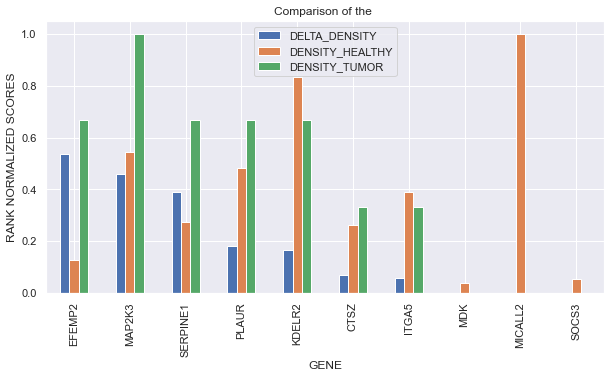

,GENE,COUNT_HEALTHY,DENSITY_HEALTHY,COUNT_TUMOR,DENSITY_TUMOR,DELTA_DENSITY
7,EFEMP2,197,0.128758,2.0,0.666667,0.537908
2,MAP2K3,830,0.542484,3.0,1.000000,0.457516
5,SERPINE1,421,0.275163,2.0,0.666667,0.391503
3,PLAUR,740,0.483660,2.0,0.666667,0.183007
1,KDELR2,1274,0.832680,2.0,0.666667,0.166013
6,CTSZ,403,0.263399,1.0,0.333333,0.069935
4,ITGA5,596,0.389542,1.0,0.333333,0.056209
0,MICALL2,1530,1.000000,NaN,NaN,NaN
8,SOCS3,83,0.054248,NaN,NaN,NaN
9,MDK,61,0.039869,NaN,NaN,NaN


In [8]:
df4 = pd.merge(df3, df2, how='left', on=['GENE'], suffixes=('_HEALTHY', '_TUMOR'))
df4['DELTA_DENSITY'] = df4.apply(lambda r: abs(r['DENSITY_TUMOR'] - r['DENSITY_HEALTHY']), axis=1)
df4.sort_values('DELTA_DENSITY', ascending=False, inplace=True)

df4_2 = df4.drop(['COUNT_HEALTHY', 'COUNT_TUMOR'], axis=1)
pd.pivot_table(df4_2, index='GENE').sort_values('DELTA_DENSITY', ascending=False).plot(
    kind='bar',
    figsize=(10, 5),
    legend=True
)
plt.title('Comparison of the ')
plt.ylabel('RANK NORMALIZED SCORES')
plt.show()

df4

### The comparison of the germline variation and somatic mutation profiles shows that EFEMP2, MAP2K3 and SERPINE1 are the genes more likely involved in brain glioma. 
By the way, this result find confirms also in other studies (references below) as stated in "EFEMP2 is upregulated in gliomas and promotes glioma cell proliferation and invasion" (from "EFEMP2 is upregulated in gliomas and promotes glioma cell proliferation and invasion") and "Mitogen activated protein kinase kinase 3 (MAP2K3), a member of the MAP-kinase family was identified to be significantly up-regulated in invasive cells" (from "MAP2K3 and p38 are drivers of in vitro glioma invasion").


References:
- Przytycki, P. F., & Singh, M. (2017). Differential analysis between somatic mutation and germline variation profiles reveals cancer-related genes. Genome medicine, 9(1), 79. https://doi.org/10.1186/s13073-017-0465-6
- Wang, Long & Chen, Qianxue & Chen, Zhibiao & Tian, Daofeng & Xu, Haitao & Cai, Qiang & Liu, Baohui & Deng, Gang. (2015). EFEMP2 is upregulated in gliomas and promotes glioma cell proliferation and invasion. International journal of clinical and experimental pathology. 8. 10385-10393. 
- Demuth, T., Rennert, J. L., Hoelzinger, D. B., Reavie, L. B., Beaudry, C., Mariani, L., & Berens, M. E. (2005). MAP2K3 and p38 are drivers of in vitro glioma invasion.